# Exercise 2: Neural Networks

In the previous exercise you implemented a binary classifier with one linear layer on a small portion of CIFAR-10. In this exercise, you will first implement a multi-class logistic regression model followed by a three layer neural network.

## Submission guidelines:

**Zip** all the files in the exercise directory excluding the data. Name the file `ex2_ID.zip`.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. 
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Do not change the functions we provided you. 
4. Write your functions in the instructed python modules only. All the logic you write is imported and used using this jupyter notebook. You are allowed to add functions as long as they are located in the python modules and are imported properly.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. Any other imports are forbidden.
6. Your code must run without errors. Use `python 3` and `numpy 1.15.4`.
7. **Before submitting the exercise, restart the kernel and run the notebook from start to finish to make sure everything works. Code that cannot run will not be tested.**
8. Write your own code. Cheating will not be tolerated. 
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support).

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
import platform
print("Python version: ", platform.python_version())
print("Numpy version: ", np.__version__)

Python version:  3.7.1
Numpy version:  1.15.4


# Logistic Regression

During this exercise, you are allowed (and encouraged) to use your code from HW1.

## Load Data - CIFAR-10

The next few cells will download and extract CIFAR-10 into `datasets/cifar10/` - notice you can copy and paste this dataset from the previous exercise or just download it again. The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The dataset is divided into five training batches and one test batch, each with 10,000 images. The test batch contains exactly 1,000 randomly-selected images from each class.


In [3]:
from datasets import load_cifar10
URL = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
PATH = 'datasets/cifar10/' # the script will create required directories
load_cifar10.maybe_download_and_extract(URL, PATH) 

Data has apparently already been downloaded and unpacked.


In [4]:
CIFAR10_PATH = os.path.join(PATH, 'cifar-10-batches-py')
X_train, y_train, X_test, y_test = load_cifar10.load(CIFAR10_PATH) # load the entire data

# define a splitting for the data
num_training = 49000
num_validation = 1000
num_testing = 1000

# add a validation dataset for hyperparameter optimization
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]
mask = range(num_validation)
X_val = X_test[mask]
y_val = y_test[mask]
mask = range(num_validation, num_validation+num_testing)
X_test = X_test[mask]
y_test = y_test[mask]

# float64
X_train = X_train.astype(np.float64)
X_val = X_val.astype(np.float64)
X_test = X_test.astype(np.float64)

# subtract the mean from all the images in the batch
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

# flatten all the images in the batch (make sure you understand why this is needed)
X_train = np.reshape(X_train, newshape=(X_train.shape[0], -1))
X_val = np.reshape(X_val, newshape=(X_val.shape[0], -1)) 
X_test = np.reshape(X_test, newshape=(X_test.shape[0], -1)) 

# add a bias term to all images in the batch
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]) 
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]) 
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]) 

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

(49000, 3073)
(1000, 3073)
(1000, 3073)


         ship         plane           dog         truck


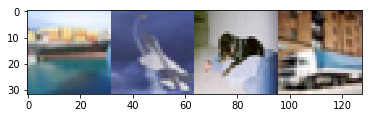

In [5]:
def get_batch(X, y, n):
    rand_items = np.random.randint(0, X.shape[0], size=n)
    images = X[rand_items]
    labels = y[rand_items]
    return X, y

def make_random_grid(x, y, n=4):
    rand_items = np.random.randint(0, x.shape[0], size=n)
    images = x[rand_items]
    labels = y[rand_items]
    grid = np.hstack((np.asarray((vec_2_img(i) + mean_image), dtype=np.int) for i in images))
    print(' '.join('%13s' % classes[labels[j]] for j in range(4)))
    return grid

def vec_2_img(x):
    x = np.reshape(x[:-1], (32, 32, 3))
    return x

X_batch, y_batch = get_batch(X_test, y_test, 4)
plt.imshow(make_random_grid(X_batch, y_batch));

Open the file `functions/classifier.py`. The constructor of the `LogisticRegression` class takes as input the dataset and labels in order to create appropriate parameters. Notice we are using the bias trick and only use the matrix `w` for convenience. Since we already have a (random) model, we can start predicting classes on images. Complete the method `predict` in the `LogisticRegression` class. **5 points**

You can use your code from HW1. If you used vectorized code well, you should make very little changes.

          car         horse         plane         plane


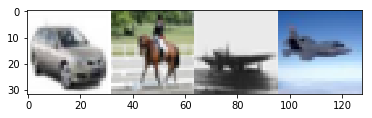

In [6]:
from functions.classifier import LogisticRegression

classifier = LogisticRegression(X_train, y_train)
y_pred = classifier.predict(X_test)
X_batch, y_batch = get_batch(X_train, y_train, 4)
plt.imshow(make_random_grid(X_batch, y_batch));

In [7]:
print(' '.join('%13s' % classes[y_pred[j]] for j in range(4)))

        plane          ship           cat          bird


In [8]:
print("model accuracy: ", classifier.calc_accuracy(X_train, y_train))

model accuracy:  10.481632653061226


## Cross-entropy

Open the file `functions/losses.py`. Complete the function `softmax_loss_vectorized` using vectorized code. This function takes as input the weights `W`, data `X`, labels `y` and a regularization term `reg` and outputs the calculated loss as a single number and the gradients with respect to W. Don't forget the regularization. **5 points**

In [9]:
from functions.losses import softmax_loss_vectorized
W = np.random.randn(3073, 10) * 0.0001
loss_naive, grad_naive = softmax_loss_vectorized(W, X_val, y_val, 0.00000)
print ('loss: %f' % (loss_naive, ))
print ('sanity check: %f' % (-np.log(0.1))) # should be close but not the same

loss: 2.394880
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? **Explain briefly.**

**Your answer:** As HW1, W is set to random number so the probability is 1 to number of classes (10).

Use the following cell to test your implementation of the gradients.

In [10]:
from functions.losses import grad_check

loss, grad = softmax_loss_vectorized(W, X_val, y_val, 1)
f = lambda w: softmax_loss_vectorized(W, X_val, y_val, 1)[0]
grad_numerical = grad_check(f, W, grad, num_checks=10)

numerical: 1.229519 analytic: 1.229519, relative error: 7.032866e-08
numerical: 1.280734 analytic: 1.280734, relative error: 2.250305e-08
numerical: -3.841398 analytic: -3.841398, relative error: 5.441730e-10
numerical: 2.633682 analytic: 2.633682, relative error: 3.725571e-08
numerical: -0.887185 analytic: -0.887185, relative error: 3.649855e-08
numerical: -5.355526 analytic: -5.355526, relative error: 8.287547e-09
numerical: 0.702801 analytic: 0.702801, relative error: 3.067012e-08
numerical: -1.679929 analytic: -1.679929, relative error: 9.066121e-10
numerical: 2.180879 analytic: 2.180879, relative error: 2.666976e-08
numerical: -1.172637 analytic: -1.172637, relative error: 2.071843e-08


In [11]:
from functions.classifier import LogisticRegression

logistic = LogisticRegression(X_train, y_train)
loss_history = logistic.train(X_train, y_train, 
                         learning_rate=1e-7,
                         reg=5e4, 
                         num_iters=1500,
                         verbose=True)

iteration 0 / 1500: loss 17.782159
iteration 100 / 1500: loss 17.517947
iteration 200 / 1500: loss 17.489498
iteration 300 / 1500: loss 17.512491
iteration 400 / 1500: loss 17.651726
iteration 500 / 1500: loss 17.842777
iteration 600 / 1500: loss 17.796509
iteration 700 / 1500: loss 17.920881
iteration 800 / 1500: loss 18.015402
iteration 900 / 1500: loss 18.113716
iteration 1000 / 1500: loss 18.122976
iteration 1100 / 1500: loss 18.277973
iteration 1200 / 1500: loss 18.296204
iteration 1300 / 1500: loss 18.415482
iteration 1400 / 1500: loss 18.519881


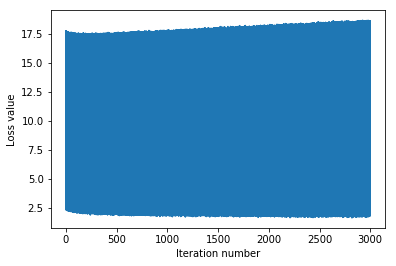

In [12]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [13]:
print("Training accuracy: ", logistic.calc_accuracy(X_train, y_train))
print("Testing accuracy: ", logistic.calc_accuracy(X_test, y_test))

Training accuracy:  38.16734693877551
Testing accuracy:  39.900000000000006


Use the validation set to tune hyperparameters by training different models (using the training dataset) and evaluating the performance using the validation dataset. Save the results in a dictionary mapping tuples of the form `(learning_rate, batch_size)` to tuples of the form `(training_accuracy, validation_accuracy)`. Finally, you should evaluate the best model on the testing dataset.

In [14]:
# You are encouraged to experiment with additional values
learning_rates = [1e-7, 5e-6]
regularization_strengths = [5e4, 1e5, 5e3, 1e2]
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_logistic = None # The LogisticRegression object that achieved the highest validation score.
################################################################################
#                            START OF YOUR CODE                                #
################################################################################
iters = 2000

for learning_rate in learning_rates:
    for reg_strength in regularization_strengths:
        log_reg = LogisticRegression(X_train, y_train)
        log_reg.train(X_train, y_train, learning_rate=learning_rate, reg=reg_strength, num_iters=iters)
        
        y_train_pred = log_reg.predict(X_train)
        acc_train = np.mean(y_train == y_train_pred)
        y_val_pred = log_reg.predict(X_val)
        acc_val = np.mean(y_val == y_val_pred)
        
        results[(learning_rate, reg_strength)] = (acc_train, acc_val)
        
        if best_val < acc_val:
            best_val = acc_val
            best_logistic = log_reg
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print ('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

test_accuracy = logistic.calc_accuracy(X_test, y_test)
print ('Binary logistic regression on raw pixels final test set accuracy: %f' % test_accuracy)

lr 1.000000e-07 reg 1.000000e+02 train accuracy: 0.390286 val accuracy: 0.386000
lr 1.000000e-07 reg 5.000000e+03 train accuracy: 0.386980 val accuracy: 0.374000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.387571 val accuracy: 0.395000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.388878 val accuracy: 0.375000
lr 5.000000e-06 reg 1.000000e+02 train accuracy: 0.391041 val accuracy: 0.357000
lr 5.000000e-06 reg 5.000000e+03 train accuracy: 0.425878 val accuracy: 0.385000
lr 5.000000e-06 reg 5.000000e+04 train accuracy: 0.407143 val accuracy: 0.364000
lr 5.000000e-06 reg 1.000000e+05 train accuracy: 0.390633 val accuracy: 0.362000
best validation accuracy achieved during cross-validation: 0.395000
Binary logistic regression on raw pixels final test set accuracy: 39.900000


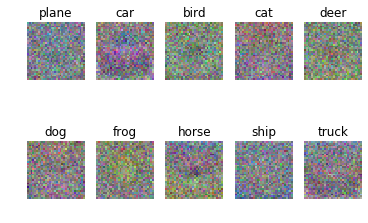

In [15]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
w = best_logistic.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
for i in range(10):
    plt.subplot(2, 5, i + 1)
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

## Neural Network

The implementation of linear regression was (hopefully) simple yet not very modular since the layer, loss and gradient were calculated as a single monolithic function. This would become impractical as we move towards bigger models. As a warmup towards `PyTorch`, we want to build networks using a more modular design so that we can implement different layer types in isolation and easily integrate them together into models with different architectures.

This logic of isolation & integration is at the heart of all popular deep learning frameworks, and is based on two methods each layer holds - a forward and backward pass. The forward function will receive inputs, weights and other parameters and will return both an output and a cache object storing data needed for the backward pass. The backward pass will receive upstream derivatives and the cache, and will return gradients with respect to the inputs and weights. By implementing several types of layers this way, we will be able to easily combine them to build classifiers with different architectures with relative ease.

We will implement a neural network to obtain better results on CIFAR-10. If you were careful, you should have got a classification accuracy of over 38% on the test set using a simple single layer network. However, using multiple layers we could reach around 50% accuracy. Our neural network will be implemented in the file `functions/neural_net.py`. We will train this network using softmax loss and L2 regularization and a ReLU non-linearity after the first two fully connected layers.

### Fully Connected Layer: Forward Pass.

Open the file `functions/layers.py` and implement the function `fc_forward` **7.5 points**.

In [16]:
np.random.seed(42)
from functions.layers import * 

num_instances = 5
input_shape = (11, 7, 3)
output_shape = 4

X = np.random.randn(num_instances * np.prod(input_shape)).reshape(num_instances, *input_shape)
W = np.random.randn(np.prod(input_shape) * output_shape).reshape(np.prod(input_shape), output_shape)
b = np.random.randn(output_shape)

out, _ = fc_forward(X, W, b)

correct_out = np.array([[16.77132953,  1.43667172, -15.60205534,   7.15789287],
                        [ -8.5994206,  7.59104298,  10.92160126,  17.19394331],
                        [ 4.77874003,  2.25606192,  -6.10944859,  14.76954561],
                        [21.21222953, 17.82329258,   4.53431782,  -9.88327913],
                        [18.83041801, -2.55273817,  14.08484003,  -3.99196171]])

print(np.isclose(out, correct_out, rtol=1e-8).all()) # simple test

True


## Fully Connected Layer: Backward Pass

Open the file `functions/layers.py` and implement the function `fc_backward` **7.5 points**.

In [17]:
np.random.seed(42)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: fc_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: fc_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: fc_forward(x, w, b)[0], b, dout)

out, cache = fc_forward(x,w,b)
dx, dw, db = fc_backward(dout, cache)

np.isclose(dw, dw_num, rtol=1e-8).all() # simple test
np.isclose(dx, dx_num, rtol=1e-8).all() # simple test
np.isclose(db, db_num, rtol=1e-8).all() # simple test

True

## ReLU: Forward Pass

Open the file `functions/layers.py` and implement the function `relu_forward` **7.5 points**.

In [18]:
x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)
out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

print(np.isclose(out, correct_out, rtol=1e-8).all()) # simple test

True


## ReLU: Backward Pass

Open the file `functions/layers.py` and implement the function `relu_backward` **7.5 points**.

In [19]:
np.random.seed(42)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)
dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)
xx, cache = relu_forward(x)
dx = relu_backward(dout, cache)

np.isclose(dx, dx_num, rtol=1e-8).all()  # simple test

True

**Optional**: you are given two helper functions in `functions/layers.py` - `fc_relu_forward` and `fc_relu_backward`. You might find it beneficial to use dedicated functions to calculate the forward and backward outputs of a fully connected layer immediately followed by a ReLU.

# Building the Network

First, notice that we are leaving behind the bias trick and removing the bias from each image. 

In [20]:
X_train = np.array([x[:-1] for x in X_train])
X_val = np.array([x[:-1] for x in X_val])
X_test = np.array([x[:-1] for x in X_test])
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(49000, 3072)
(1000, 3072)
(1000, 3072)


Open the file `functions/neural_net.py` and complete the class `ThreeLayerNet`. All the implementation details are available in the file itself. Read the documentation carefully since the class of this network is slightly different from the network in the previous section of this exercise. **50 points**

In [21]:
from functions.neural_net import ThreeLayerNet
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
model = ThreeLayerNet(input_size, hidden_size, num_classes)

In [22]:
stats = model.train(X_train, y_train, X_val, y_val,
            num_iters=1500, batch_size=200,
            learning_rate=1e-3, reg=0, verbose=True)

iteration 0 / 1500: loss 2.312956
iteration 100 / 1500: loss 2.249321
iteration 200 / 1500: loss 2.086512
iteration 300 / 1500: loss 2.018157
iteration 400 / 1500: loss 1.911787
iteration 500 / 1500: loss 1.937864
iteration 600 / 1500: loss 1.896783
iteration 700 / 1500: loss 1.907318
iteration 800 / 1500: loss 1.738480
iteration 900 / 1500: loss 1.787154
iteration 1000 / 1500: loss 1.678832
iteration 1100 / 1500: loss 1.731679
iteration 1200 / 1500: loss 1.722333
iteration 1300 / 1500: loss 1.657725
iteration 1400 / 1500: loss 1.607732


In [23]:
val_acc = (model.predict(X_val) == y_val).mean()
print ('Validation accuracy: ', val_acc)

Validation accuracy:  0.413


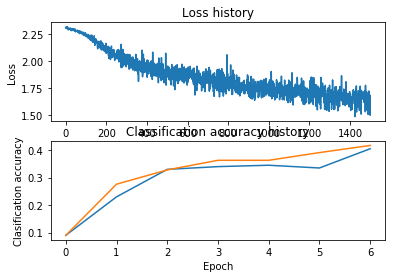

In [24]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

Use the validation set to tune hyperparameters by training different models (using the training dataset) and evaluating the performance using the validation dataset. Save the results in a dictionary mapping tuples of the form `(learning_rate, hidden_size, regularization)` to tuples of the form `(training_accuracy, validation_accuracy)`. You should evaluate the best model on the testing dataset and print out the training, validation and testing accuracies for each of the models and provide a clear visualization. Highlight the best model w.r.t the testing accuracy. **10 points**

In [ ]:
# You are encouraged to experiment with additional values
learning_rates = [ 1e-3, 1e-6, 5e-3, 5e-6] # this time its up to you
hidden_sizes = [50, 100, 200, 500, 1000,] # this time its up to you
regularizations = [0, 1e-3, 1e-6, 5e-6, 5e-9 , 1,] # this time its up to you

results = {}
best_val = -1   
best_net = None 
################################################################################
#                            START OF YOUR CODE                                #
################################################################################
best_values = None

for hs in hidden_sizes:
    for lr in learning_rates:
        for r in regularizations:
            model = ThreeLayerNet(input_size, hs, num_classes)
            stats = model.train(X_train, y_train, X_val, y_val,
                                num_iters=1500, batch_size=200,
                                learning_rate=lr, reg=r, verbose=False)
            val_accuracy = (model.predict(X_val) == y_val).mean()
            train_accuracy = (model.predict(X_train) == y_train).mean()
            print('(learning_rate, hidden_size, regularization) = {}'.format((lr, hs, r)))
            print('(train_accuracy,val_accuracy) = {}'.format((train_accuracy,val_accuracy)))
            results[(lr, hs, r)] = (train_accuracy,val_accuracy)
            if val_accuracy > best_val:
                best_val = val_accuracy
                best_values = [(lr, hs, r), (train_accuracy, val_accuracy), ]
                best_net = model
            

print('best training values = {}, got use the best accuracy, val - {} train - {}'
      .format(best_values[0],best_values[1][0], best_values[1][1]))
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(learning_rate, hidden_size, regularization) = (0.001, 50, 0)
(train_accuracy,val_accuracy) = (0.4101224489795918, 0.398)
(learning_rate, hidden_size, regularization) = (0.001, 50, 0.001)
(train_accuracy,val_accuracy) = (0.4099795918367347, 0.395)
(learning_rate, hidden_size, regularization) = (0.001, 50, 1e-06)
(train_accuracy,val_accuracy) = (0.41608163265306125, 0.397)
(learning_rate, hidden_size, regularization) = (0.001, 50, 5e-06)
(train_accuracy,val_accuracy) = (0.4155714285714286, 0.414)
(learning_rate, hidden_size, regularization) = (0.001, 50, 5e-09)
(train_accuracy,val_accuracy) = (0.4164081632653061, 0.399)
(learning_rate, hidden_size, regularization) = (0.001, 50, 1)
(train_accuracy,val_accuracy) = (0.272734693877551, 0.287)
(learning_rate, hidden_size, regularization) = (1e-06, 50, 0)
(train_accuracy,val_accuracy) = (0.11881632653061225, 0.135)
(learning_rate, hidden_size, regularization) = (1e-06, 50, 0.001)
(train_accuracy,val_accuracy) = (0.10673469387755102, 0.108)
(l

## Inline Question 2:
What can you say about the training? Why does it take much longer to train? How could you speed up computation? What would happen to the network accuracy and training time when adding additional layer? What about additional hidden neurons?

**Your answer:** 
*THe  training process takes much longer, We think that it takes much longer to run because we added more layers which means more neurons and the forward and backwards passes takes high computaional effort (derivetive and loss for each)
we could speed up the computation by using GPU, stronger CPU and writing a better efficeint code, maybe using C++ could improve python overhead.

If we would add more layer the training time will increase, while the accuuracy might improve and might not.
Same goes for hidden neurons *

## Bonus 
Train a 5 hidden layer network with varying hidden layer size and plot the loss function and train / validation accuracies. **5 points**

In [ ]:
## Your code here ##